In [1]:
import json
import os
import random
import cv2
from imageio import imread
import matplotlib.pyplot as plt
import numpy as np

import detectron2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [2]:
DATASET1_CLASS_MAPPING = {
    'face_with_mask': 0,
    'face_no_mask': 1,
    'face_with_mask_incorrect': 2,
    'face_other_covering': 1,
    'mask_surgical': -1,
    'face_shield': -1,
    'hat': -1, 
    'eyeglasses': -1, 
    'mask_colorful': -1,
    'helmet': -1,
    'sunglasses': -1,
    'scarf_bandana': -1,
    'hair_net': -1,
    'goggles': -1,
    'hijab_niqab': -1,
    'turban': -1,
    'balaclava_ski_mask': -1,
    'gas_mask': -1,
    'hood': -1,
    'other': -1}

In [3]:
def get_facemask_1_dicts(dataset_dir, split='train'):
    """
    Return a dictionary containing the dataset's annotations.
    
    Args:
        dataset_dir (str): path to the dataset parent directory
        split (str): get annotations for 'train', 'val', or 'test' split. Default: 'train'
            note: fixed train:val:test split ratio of 0.7:0.15:0.15
    """
    img_dir = os.path.join(dataset_dir, "images")
    annotation_dir = os.path.join(dataset_dir, "annotations")
    annot_file_path_list = []
    for file in sorted(os.listdir(annotation_dir)):
        annot_file_path_list.append(os.path.join(annotation_dir, file))

    # random shuffle files list
    random.seed(3)
    random.shuffle(annot_file_path_list)
    
    # tain, val, test splits
    num_files = len(annot_file_path_list)
    train_index, val_index = int(num_files * 0.7), int(num_files * 0.85)
    
    train_set = annot_file_path_list[:train_index]
    val_set = annot_file_path_list[train_index:val_index]
    test_set = annot_file_path_list[val_index:]
    
    splits = {
        "train": train_set,
        "val": val_set,
        "test": test_set
    }
    
    dataset_dicts = []
    # loop over all annotation json files
    for idx, file in enumerate(splits.get(split)):
        with open(file) as json_file:
            data = json.load(json_file)  # type: dict
            annotations = data["Annotations"]  # type: list
        
        img_path = os.path.join(img_dir, data["FileName"])
        img = imread(img_path)
        height, width, _ = img.shape
        
        record = {}
        record["file_name"] = img_path
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        
        objs = []
        for annot in annotations:
            classname = annot["classname"]
            bbox = np.array(annot["BoundingBox"])
            category_id = DATASET1_CLASS_MAPPING[classname]
            if category_id == -1:
                continue
            obj = {
                "bbox": bbox,
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": category_id,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


In [4]:
dataset_dir = "./datasets/dataset1/Medical_mask/Medical_mask/Medical_Mask/"
for d in ["train", "val"]:
    DatasetCatalog.register("facemask_1_" + d, lambda d=d: get_facemask_1_dicts(dataset_dir, d))
    MetadataCatalog.get("facemask_1_" + d).set(thing_classes=['face_with_mask', 'face_no_mask', 'face_with_mask_incorrect', 'face_other_covering'],
                                              evaluator_type="coco")


In [5]:
facemask_1_metadata = MetadataCatalog.get("facemask_1_train")

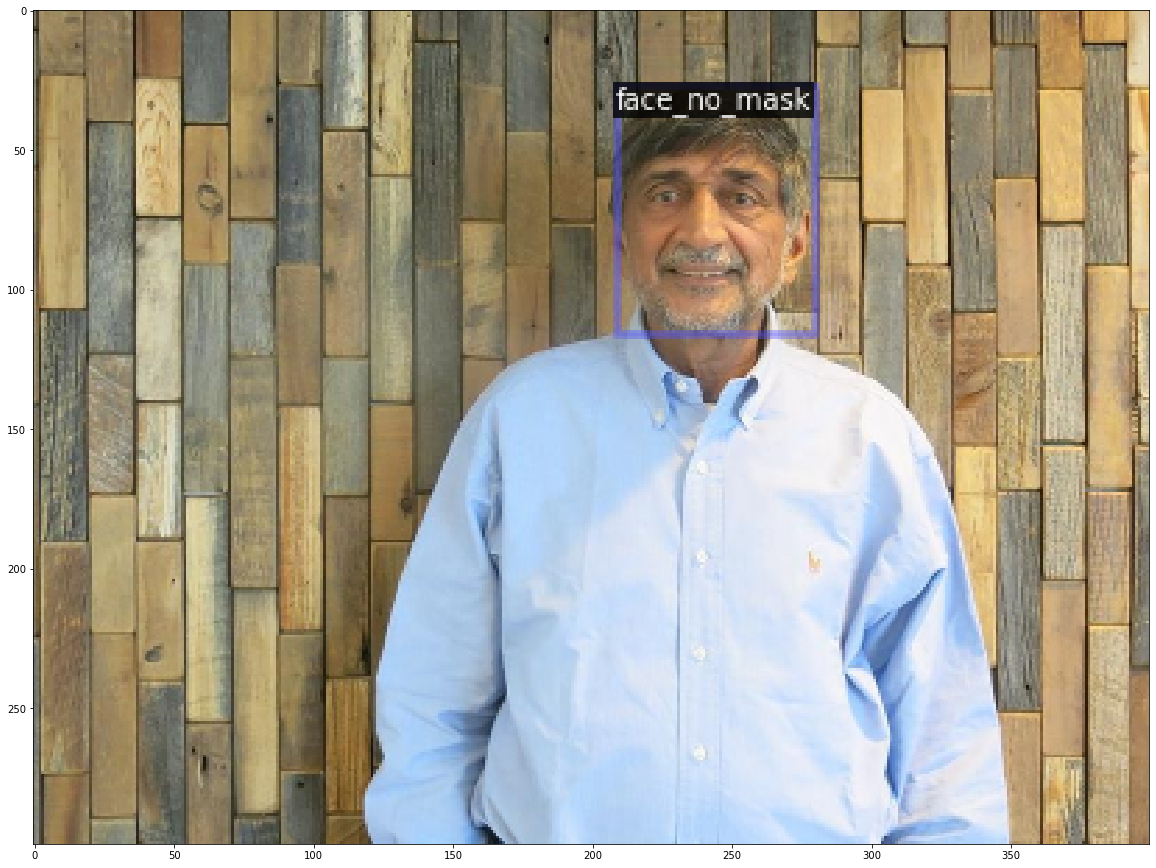

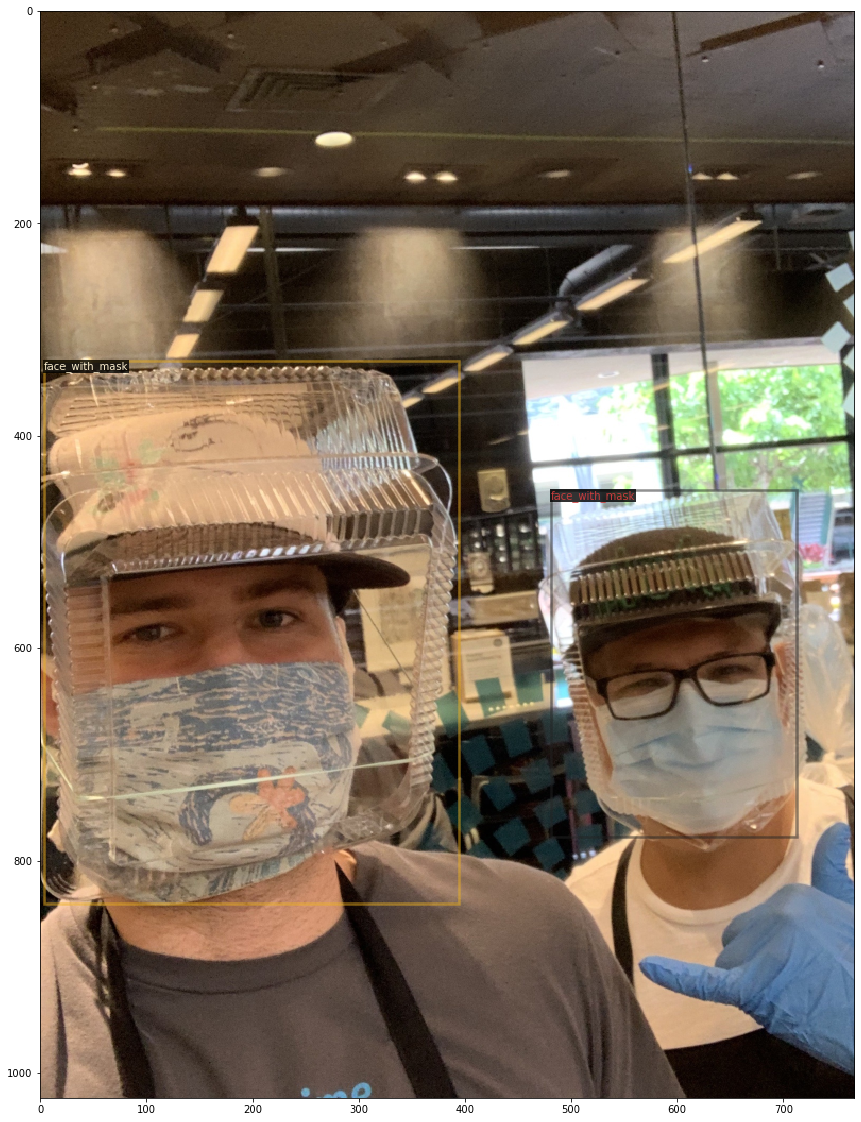

In [6]:
dataset_dicts = get_facemask_1_dicts(dataset_dir, "train")
# select two samples to verify the data loading is correct
for d in dataset_dicts[5:7]:
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=facemask_1_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    plt.figure(figsize=(20, 20))
    plt.imshow(out.get_image())
    plt.show()
